In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install tensorflow-addons

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
#import tensorflow_addons as tfa
from imutils import paths
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import matplotlib.pyplot as plt
#matplotlib.use("Agg")
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight




## Qual GPU está sendo usada

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Dec 28 20:32:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
BS = 32
img_height = 224
img_width = 224

INIT_LR = 0.01
EPOCHS = 300

SEED = 42

In [ ]:
#data_dir = list(paths.list_images("/content/drive/My Drive/mosquitoes-datasets/base01"))
train_dir = "/content/drive/My Drive/mosquitoes-datasets/parted/base03/train"
validation_dir = "/content/drive/My Drive/mosquitoes-datasets/parted/base03/validation"
test_dir = "/content/drive/My Drive/mosquitoes-datasets/parted/base03/test"

In [ ]:
	train_datagen = ImageDataGenerator(
    rescale=1./255,
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest",)

In [ ]:
    val_datagen = ImageDataGenerator(
    rescale=1./255,)

In [ ]:
    test_datagen = ImageDataGenerator(
    rescale=1./255,)

In [ ]:
train_ds = train_datagen.flow_from_directory(
  directory = train_dir,
  target_size=(img_height, img_width),
  batch_size=BS,
  seed=SEED,
  class_mode='categorical',)

Found 3802 images belonging to 6 classes.


In [ ]:
val_ds = val_datagen.flow_from_directory(
  directory = validation_dir,
  target_size=(img_height, img_width),
  batch_size=BS,
  seed=SEED,
  class_mode='categorical',)


Found 815 images belonging to 6 classes.


In [ ]:
test_ds = test_datagen.flow_from_directory(
  directory = test_dir,
  target_size=(img_height, img_width),
  batch_size=BS,
  shuffle=False,
  seed=SEED,
  class_mode='categorical',)


Found 815 images belonging to 6 classes.


In [ ]:
class_names = train_ds.class_indices
print(class_names)

{'aae-femea': 0, 'aae-macho': 1, 'aal-femea': 2, 'aal-macho': 3, 'cq-femea': 4, 'cq-macho': 5}


In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()

opt = tf.keras.optimizers.SGD(lr=INIT_LR)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_ds.classes), 
            y = train_ds.classes)

train_class_weights = dict(enumerate(class_weights))

In [ ]:
model = tf.keras.applications.VGG16(include_top=True,
                                             weights=None,
                                             input_shape=(img_height,img_width,3),
                                             classes=6)

In [ ]:
model.compile(loss=loss_fn,optimizer = opt, metrics = ['accuracy'])

In [ ]:
# simple early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
H = model.fit(train_ds,batch_size=BS,
              validation_data=val_ds,
              class_weight=train_class_weights,
              epochs=EPOCHS,
              callbacks=[es])

Epoch 1/300
119/119 [==============================] - 1045s 9s/step - loss: 1.7920 - accuracy: 0.1633 - val_loss: 1.7918 - val_accuracy: 0.1828
Epoch 2/300
119/119 [==============================] - 101s 851ms/step - loss: 1.7918 - accuracy: 0.1704 - val_loss: 1.7914 - val_accuracy: 0.1448
Epoch 3/300
119/119 [==============================] - 101s 850ms/step - loss: 1.7914 - accuracy: 0.1625 - val_loss: 1.7907 - val_accuracy: 0.3411
Epoch 4/300
119/119 [==============================] - 101s 851ms/step - loss: 1.7908 - accuracy: 0.2059 - val_loss: 1.7898 - val_accuracy: 0.2123
Epoch 5/300
119/119 [==============================] - 102s 859ms/step - loss: 1.7899 - accuracy: 0.2328 - val_loss: 1.7887 - val_accuracy: 0.2491
Epoch 6/300
119/119 [==============================] - 102s 854ms/step - loss: 1.7883 - accuracy: 0.2304 - val_loss: 1.7857 - val_accuracy: 0.3607
Epoch 7/300
119/119 [==============================] - 102s 857ms/step - loss: 1.7857 - accuracy: 0.2496 - val_loss: 1.7

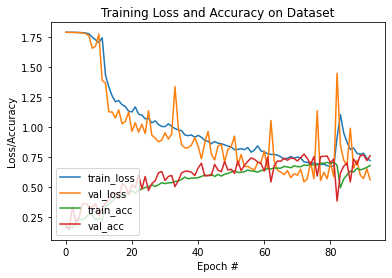

In [ ]:
if es.stopped_epoch!=0:
  EPOCHS = es.stopped_epoch+1

  
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
#plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")
plt.show()

##Teste

## Get the accuracy score

In [ ]:
test_score = model.evaluate(test_ds)



print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 

print("[INFO] Loss: ",test_score[0])

26/26 [==============================] - 196s 8s/step - loss: 0.5953 - accuracy: 0.7423
[INFO] accuracy: 74.23%
[INFO] Loss:  0.5952956676483154


## Plot the confusion matrix. Set Normalize = True/False

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

## Print the Target names

In [ ]:
target_names = []

for key in train_ds.class_indices:

    target_names.append(key)



print(target_names)

['aae-femea', 'aae-macho', 'aal-femea', 'aal-macho', 'cq-femea', 'cq-macho']


## Confution Matrix

Confusion Matrix
Confusion matrix, without normalization


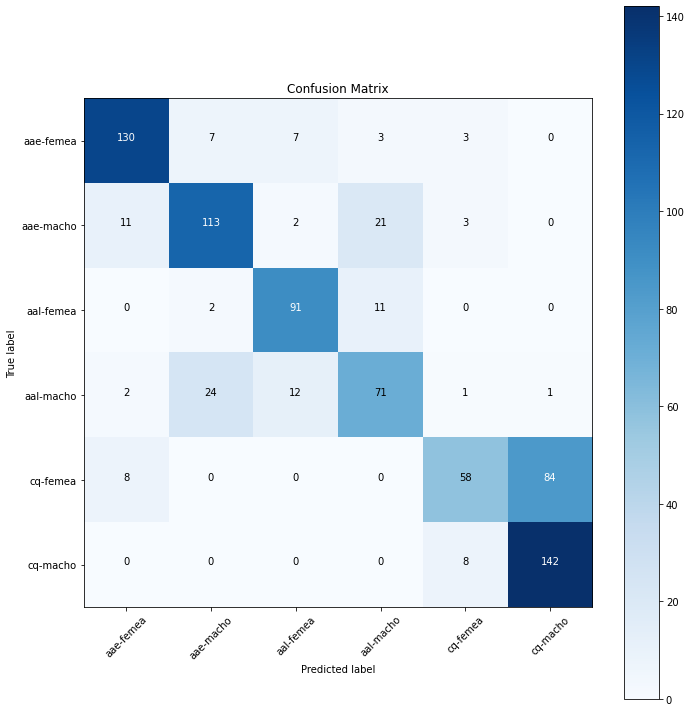

In [ ]:
Y_pred = model.predict(test_ds)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(test_ds.classes, y_pred)

plot_confusion_matrix(cm, target_names, False, title='Confusion Matrix')

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)

## Print Classification Report

In [ ]:
print('Classification Report')

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   aae-femea       0.86      0.87      0.86       150
   aae-macho       0.77      0.75      0.76       150
   aal-femea       0.81      0.88      0.84       104
   aal-macho       0.67      0.64      0.65       111
    cq-femea       0.79      0.39      0.52       150
    cq-macho       0.63      0.95      0.75       150

    accuracy                           0.74       815
   macro avg       0.76      0.74      0.73       815
weighted avg       0.76      0.74      0.73       815



## Serialize model to JSON

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Curva ROC

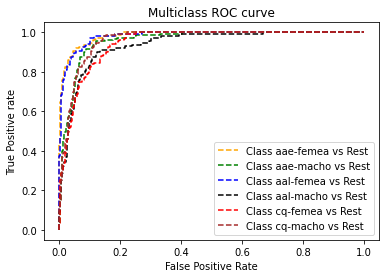

In [ ]:
#ROC CURVE
from sklearn.metrics import roc_curve



# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 6

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_ds.classes, Y_pred[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class aae-femea vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class aae-macho vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class aal-femea vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='black', label='Class aal-macho vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class cq-femea vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='brown', label='Class cq-macho vs Rest')


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);